# Group project

By delivering this notebook, we confirm that the group project was developed by the following students.

## Student 1: Niclas Michael Groll, 48699 
## Student 2: Constantin Baumann, 49620 


The group project will focus on analysing data on flights in the US.

Unless otherwise specified, the problems can be solved using either Spark or Pandas.

Some useful links:

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)


*Information on Colab/Docker from the group: Both Colab and Jupyter Notebook (including Docker) were used to create this group work. The final run of the solutions below was done in Colab.*

## Colab setup 

The following cell will install Spark, if the notebook is running on COLAB. Before running this cell, you should access the following link [https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing](https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing)

In [2]:
#Run this cell to install Spark on Colab
import os

if 'COLAB_GPU' in os.environ : 
    !apt-get install openjdk-8-jdk-headless
    !pip install pyspark==3.1.2
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.1-s_2.12/graphframes-0.8.2-spark3.1-s_2.12.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.2-spark3.1-s_2.12.jar pyspark-shell'

    from google.colab import drive
    drive.mount('/content/drive')



Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u292-b10-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u292-b10-0ubuntu1~18.04 [8,284 kB]
Fetched 36.5 MB in 2s (17.2 MB/s)
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database

## Local setup

For running the group project locally, you should create a directory named **data** in the directory where you have this notebook. Then, you should download to the **data** directory the files in the following link: [https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing](https://drive.google.com/drive/folders/1hylIwkzcOWjYMQW2wWSVRmAN9mEyGToP?usp=sharing).

## Initialization

Import libraries. 

In [3]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *

plt.style.use('seaborn')

print(pyspark.__version__)

3.1.2


Let's start spark session and set *log* level to ERROR.

In [4]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Group project") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

if 'COLAB_GPU' in os.environ : 
    spark.sparkContext.addPyFile('graphframes-0.8.2-spark3.1-s_2.12.jar')
elif 'DATABRICKS_RUNTIME_VERSION' in os.environ : 
    # TO BE COMPLETE
    ;
else:
    spark.sparkContext.addPyFile('/usr/local/spark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar')


spark.sparkContext.setLogLevel("ERROR")

## Data selection

This cell controls the dataset you will be using. Note that this cell will control the path to the files, dependening on the platform you are using to run the code.


In [5]:
# Comment the following 
#flightsF = "sample.csv"
#flightsF = "complete.csv"
#flightsF = "data-2009.csv"
#flightsF = "data-2010.csv"
#flightsF = "data-2011.csv"
#flightsF = "data-2012.csv"
#flightsF = "data-2013.csv"
#flightsF = "data-2014.csv"
#flightsF = "data-2015.csv"
flightsF = "data-2016.csv"
#flightsF = "data-2017.csv"
#flightsF = "data-2018.csv"

if 'COLAB_GPU' in os.environ : 
    FLIGHTS_FILENAME = "/content/drive/MyDrive/group2122/" + flightsF
    AIRPORTS_FILENAME = "/content/drive/MyDrive/group2122/airports.csv"
    HOLIDAYS_FILENAME = "/content/drive/MyDrive/group2122/holidays.csv"
elif 'DATABRICKS_RUNTIME_VERSION' in os.environ : 
    # TO BE COMPLETE
    ;
else:
    FLIGHTS_FILENAME = os.path.join( "data", flightsF)
    AIRPORTS_FILENAME = os.path.join( "data", "airports.csv")
    HOLIDAYS_FILENAME = os.path.join( "data", "holidays.csv")


## Datasets

This section describes the datasets you have available for your analysis.

### Flights

The flights dataset, generated from data available at [https://www.transtats.bts.gov/DataIndex.asp](https://www.transtats.bts.gov/DataIndex.asp), includes the following columns:

* FL_DATE: date of the flight (format: yyyy-mm-dd)
* OP_CARRIER: carrier code
* OP_CARRIER_FL_NUM: carrier flight number
* ORIGIN: origin airport (using IATA codes)
* DEST: destination airport (using IATA codes)
* CRS_DEP_TIME: scheduled local departure time (format for all times: hh:mm)
* DEP_TIME: actual departure time
* DEP_DELAY: departure delay, in minutes
* TAXI_OUT: taxi out time
* WHEELS_OFF: actual local wheel off time
* WHEELS_ON: actual local wheel on time
* TAXI_IN: actual local taxi in time
* CRS_ARR_TIME: scheduled local arrival time
* ARR_TIME: actual arrival time
* ARR_DELAY: arrival delay, in minutes
* CANCELLED: 1 if the flight has been cancelled; 0 otherwise
* CANCELLATION_CODE: code of cancelation (A = carrier, B = weather, C = NAS, D = security)
* DIVERTED: 1 if the flight has been diverted; 0 otherwise
* CRS_ELAPSED_TIME: estimated elapsed time
* ACTUAL_ELAPSED_TIME: actual elapsed time
* AIR_TIME: flight time, in minutes
* DISTANCE: flight distance, in miles
* CARRIER_DELAY: delay due to carrier, in minutes
* WEATHER_DELAY: delay due to weather, in minutes
* NAS_DELAY: delay due to NAS, in minutes
* SECURITY_DELAY: delay due to security, in minutes
* LATE_AIRCRAFT_DELAY: delay due to late aircraft, in minutes

The following data files are available:

* complete.csv : complete data set, including data from 2009 to 2018
* sample.csv : sample data set, including data from July 1 to July 15, from years 2009 to 2018
* data-20xx.csv : data set for a particular year

Load the dataset into flightsDF dataframe and register flights under view name **flights**. We are setting the schema programmatically, because inferring the schema in a very large dataframe is slow.


In [6]:
flightsSchema = StructType([
    StructField("FL_DATE", DateType()),
    StructField("OP_CARRIER", StringType()),
    StructField("OP_CARRIER_FL_NUM", IntegerType()),
    StructField("ORIGIN", StringType()),
    StructField("DEST", StringType()),
    StructField("CRS_DEP_TIME", StringType()),
    StructField("DEP_TIME", StringType()),
    StructField("DEP_DELAY", IntegerType()),
    StructField("TAXI_OUT", IntegerType()),
    StructField("WHEELS_OFF", StringType()),
    StructField("WHEELS_ON", StringType()),
    StructField("TAXI_IN", IntegerType()),
    StructField("CRS_ARR_TIME", StringType()),
    StructField("ARR_TIME", StringType()),
    StructField("ARR_DELAY", IntegerType()),
    StructField("CANCELLED", IntegerType()),
    StructField("CANCELLATION_CODE", StringType()),
    StructField("DIVERTED", IntegerType()),
    StructField("CRS_ELAPSED_TIME", IntegerType()),
    StructField("ACTUAL_ELAPSED_TIME", IntegerType()),
    StructField("AIR_TIME", IntegerType()),
    StructField("DISTANCE", IntegerType()),
    StructField("CARRIER_DELAY", IntegerType()),
    StructField("WEATHER_DELAY", IntegerType()),
    StructField("NAS_DELAY", IntegerType()),
    StructField("SECURITY_DELAY", IntegerType()),
    StructField("LATE_AIRCRAFT_DELAY", IntegerType())
    ])

flightsDF = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)

flightsDF.createOrReplaceTempView("flights")

flightsDF.show(3)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|2016-01-01|        DL|             1

### Airports

The airports dataset includes the information about US airports - soure: [https://datahub.io/core/airport-codes](https://datahub.io/core/airport-codes).

This dataset includes the following columns:

* ident: identifier
* type: type of airport
* name: name of airport
* elevation_ft: altitude, in feets
* continent: code of continent
* iso_country: coide of country
* iso_regio: code of region
* municipality: city
* gps_code: code of GPS
* iata_code: IATA code of aurport
* local_code: local code of airport
* coordinates: coordinates of airport

Load the dataset into airportDF dataframe and register airports under view name **airports**.


In [7]:
airportsDF = spark.read.option("header", True).option("inferSchema",True).csv(AIRPORTS_FILENAME)

airportsDF.createOrReplaceTempView("airports")

airportsDF.show(3)


+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|  00A|     heliport|   Total Rf Heliport|          11|       NA|         US|     US-PA|    Bensalem|     00A|     null|       00A|-74.9336013793945...|
| 00AA|small_airport|Aero B Ranch Airport|        3435|       NA|         US|     US-KS|       Leoti|    00AA|     null|      00AA|-101.473911, 38.7...|
| 00AK|small_airport|        Lowell Field|         450|       NA|         US|     US-AK|Anchor Point|    00AK|     null|      00AK|-151.695999146, 5...|
+-----+-------------+--------------------+------------+---------+-----------+-----

Exemplify how you can plot information about airports.

Plotting airport location - using altitude for different color


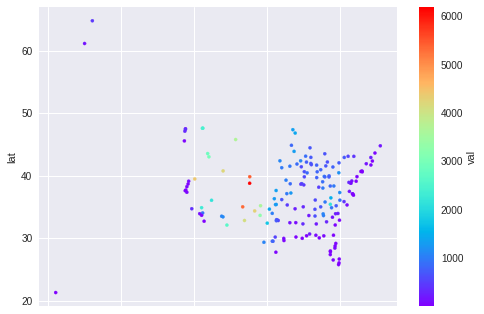

In [8]:
airportLocDF = spark.sql("""SELECT FLOAT(TRIM(SUBSTRING_INDEX(coordinates,',',1))) AS lon,
                                    FLOAT(TRIM(SUBSTRING_INDEX(coordinates,',',-1))) AS lat,
                                    elevation_ft AS val
                        FROM airports 
                        WHERE type = 'large_airport' AND continent = 'NA' AND iso_country = 'US'""")

print('Plotting airport location - using altitude for different color')
airportLocPD = airportLocDF.toPandas()
airportLocPD.plot(x="lon",y="lat",c="val",s=10,cmap="rainbow",kind="scatter")


### Public holidays

Dates of public holidays in the US.

This dataset includes the following columns:

* Date: date (format: yyyy-mm-dd)
* Holiday: name of the holiday
* WeekDay: day of week
* Month: month (1-12)
* Day: day (1-31)
* Year: year (2002-2021)

Load the dataset into holidaysDF dataframe and register holidays under view name **holidays**.


In [9]:
holidaysDF = spark.read.option("header", True).option("inferSchema",True).csv(HOLIDAYS_FILENAME)

holidaysDF.createOrReplaceTempView("holidays")

holidaysDF.show(3)


+----------+-----------+-------+-----+---+----+
|      Date|    Holiday|WeekDay|Month|Day|Year|
+----------+-----------+-------+-----+---+----+
|2004-07-04|4th of July| Sunday|    7|  4|2004|
|2005-07-04|4th of July| Monday|    7|  4|2005|
|2006-07-04|4th of July|Tuesday|    7|  4|2006|
+----------+-----------+-------+-----+---+----+
only showing top 3 rows



## Problem 0 [1 point]

We start by executing some simple statistics to compare the execution time between Spark and Pandas.


### Code: Spark

In [10]:
start_time = time.time()

flightsSchema = StructType([
    StructField("FL_DATE", DateType()),
    StructField("OP_CARRIER", StringType()),
    StructField("OP_CARRIER_FL_NUM", IntegerType()),
    StructField("ORIGIN", StringType()),
    StructField("DEST", StringType()),
    StructField("CRS_DEP_TIME", StringType()),
    StructField("DEP_TIME", StringType()),
    StructField("DEP_DELAY", IntegerType()),
    StructField("TAXI_OUT", IntegerType()),
    StructField("WHEELS_OFF", StringType()),
    StructField("WHEELS_ON", StringType()),
    StructField("TAXI_IN", IntegerType()),
    StructField("CRS_ARR_TIME", StringType()),
    StructField("ARR_TIME", StringType()),
    StructField("ARR_DELAY", IntegerType()),
    StructField("CANCELLED", IntegerType()),
    StructField("CANCELLATION_CODE", StringType()),
    StructField("DIVERTED", IntegerType()),
    StructField("CRS_ELAPSED_TIME", IntegerType()),
    StructField("ACTUAL_ELAPSED_TIME", IntegerType()),
    StructField("AIR_TIME", IntegerType()),
    StructField("DISTANCE", IntegerType()),
    StructField("CARRIER_DELAY", IntegerType()),
    StructField("WEATHER_DELAY", IntegerType()),
    StructField("NAS_DELAY", IntegerType()),
    StructField("SECURITY_DELAY", IntegerType()),
    StructField("LATE_AIRCRAFT_DELAY", IntegerType())
    ])

flightsDF = spark.read.option("header", True).schema(flightsSchema).csv(FLIGHTS_FILENAME)

flightsDF.createOrReplaceTempView("flights_new")

result = spark.sql("SELECT OP_CARRIER, count(*) AS num_flights FROM flights_new GROUP BY OP_CARRIER")
result.show()

end_time = time.time()
print( "Runtime = " + str(end_time - start_time))



+----------+-----------+
|OP_CARRIER|num_flights|
+----------+-----------+
|        UA|     545067|
|        NK|     138199|
|        AA|     914495|
|        EV|     490990|
|        B6|     282473|
|        DL|     922746|
|        OO|     605933|
|        F9|      95121|
|        HA|      76789|
|        AS|     177280|
|        VX|      69121|
|        WN|    1299444|
+----------+-----------+

Runtime = 22.172283172607422


* Execution time for sample.csv: **8,17 Seconds** (rounded)
* Execution time for complete.csv: **200,1 Seconds** (rounded)

Using GPU @ Colab (go to Execution time menu and change the type of execution time to include GPU):

* Execution time for sample.csv: **12,37 Seconds** (rounded)
* Execution time for complete.csv: **191,99 Seconds** (rounded)

*Disclaimer: Numbers (runtime) vary per execution. We took the numbers from a specially conducted run using the sample and the complete dataset. Hence, variations between written numbers and the displayed showtime can occur.*

### Code: Pandas library

In [11]:
import pandas as pd
import time

start_time = time.time()
mySchema = {"FL_DATE": "str",
            "OP_CARRIER": "str",
            "OP_CARRIER_FL_NUM":"Int64",
            "ORIGIN":"str",
            "DEST":"str",
            "CRS_DEP_TIME":"str",
            "DEP_TIME":"str",
            "DEP_DELAY":"Int64",
            "TAXI_OUT":"Int64",
            "WHEELS_OFF":"str",
            "WHEELS_ON":"str",
            "TAXI_IN":"Int64",
            "CRS_ARR_TIME":"str",
            "ARR_TIME":"str",
            "ARR_DELAY":"Int64",
            "CANCELLED":"Int64",
            "CANCELLATION_CODE":"str",
            "DIVERTED":"Int64",
            "CRS_ELAPSED_TIME":"Int64",
            "ACTUAL_ELAPSED_TIME":"Int64",
            "AIR_TIME":"Int64",
            "DISTANCE":"Int64",
            "CARRIER_DELAY":"Int64",
            "WEATHER_DELAY":"Int64",
            "NAS_DELAY":"Int64",
            "SECURITY_DELAY":"Int64",
            "LATE_AIRCRAFT_DELAY":"Int64"
           }

dataframe = pd.read_csv(FLIGHTS_FILENAME,dtype=mySchema)
result = dataframe[["FL_DATE","OP_CARRIER"]].groupby("OP_CARRIER").count()
print(result)

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


            FL_DATE
OP_CARRIER         
AA           914495
AS           177280
B6           282473
DL           922746
EV           490990
F9            95121
HA            76789
NK           138199
OO           605933
UA           545067
VX            69121
WN          1299444
Runtime = 60.10528302192688


* Execution time for sample.csv: **17,89 Seconds** (rounded)
* Execution time for complete.csv: **Kernel died, not enough computing power to execute the task locally (even though we ran it on a powerful MacPro M1). Also while using the Colab, we weren't able to finish the computation. We stopped the run after apprx. 10 minutes.**

**Discuss the results you have obtained:**
<br>
<br>PySpark was able to execute the task much faster than Python (apprx. 2x faster with the "Sample" dataset & with the "Complete" dataset Pandas was not even able to execute the task). The issue is that Pandas doesn’t scale - with Pandas, processing itself is single threaded and cannot be distributed to different machines. Pandas requires that all of your data fit into the main memory of you local computer. It can neither spill data to disk nor can it distribute data within a cluster of machines. Hence, if a data set grows, you need more RAM and a faster CPU (in terms of single core performance, it doesn’t make good use of multiple CPUs). On the one hand is this a natural limitation of Pandas, however, on the other hand, this feature keeps the entire library simple and easy to use (especially for less extensive datasets).
<br>Spark, however, is multi threaded and can make use of all cores of a machine. Spark scales very well with huge amounts of data via multiple machines in a cluster. By breaking down the total amount of work into individual tasks ("lazy execution model"), which then can be processed independently (as soon as each tasks input data is available) in parallel, Spark makes very efficient use of the available cluster resources. Therefore, for large datasets with limited numbers of columns, Spark has a much faster execution time than Pandas.
 

_______

In [12]:
print("For the solutions of the problems, the following dataset was used:", flightsF) 

For the solutions of the problems, the following dataset was used: data-2016.csv


_______________

## Problem 1 [4 points] 

In this first problem, you should compute a set of statistics on the data.


### Top-20 airports with more flights (include the name of the airport)

In [13]:
# TO COMPLETE

originAirports = spark.sql("""SELECT ORIGIN, count(*) as departures 
                                    FROM flights_new 
                                    GROUP BY ORIGIN 
                                    ORDER BY departures DESC
                           """)

destAirports = spark.sql("""SELECT DEST, count(*) as arrivals 
                                    FROM flights_new 
                                    GROUP BY DEST 
                                    ORDER BY arrivals DESC
                         """)

MostFlightsByAirports = spark.sql("""with destination as (SELECT DEST, count(*) as arrivals 
                                            from flights_new GROUP BY DEST ORDER BY arrivals DESC),
                                            origin as (SELECT ORIGIN, count(*) as departures 
                                            from flights_new GROUP BY ORIGIN ORDER BY departures DESC)
                                            SELECT ORIGIN, (destination.arrivals+origin.departures) as Total_Flights
                                            from origin, destination 
                                            where ORIGIN = DEST
                                            order by (origin.departures + destination.arrivals) DESC
                                            limit 20""").createOrReplaceTempView("most_flights_airport")


top20byairport = spark.sql("""SELECT ORIGIN, name, Total_Flights 
                                     FROM (SELECT * FROM most_flights_airport LEFT join airports on most_flights_airport.ORIGIN = airports.iata_code)""")
top20byairport.show()


+------+--------------------+-------------+
|ORIGIN|                name|Total_Flights|
+------+--------------------+-------------+
|   ATL|Hartsfield Jackso...|       768627|
|   ORD|Chicago O'Hare In...|       487971|
|   DEN|Denver Internatio...|       452361|
|   LAX|Los Angeles Inter...|       425955|
|   DFW|Dallas Fort Worth...|       392080|
|   SFO|San Francisco Int...|       344756|
|   PHX|Phoenix Sky Harbo...|       318290|
|   LAS|McCarran Internat...|       301376|
|   IAH|George Bush Inter...|       274184|
|   SEA|Seattle Tacoma In...|       265252|
|   MSP|Minneapolis-St Pa...|       258382|
|   MCO|Orlando Internati...|       251444|
|   DTW|Detroit Metropoli...|       248086|
|   BOS|General Edward La...|       242513|
|   EWR|Newark Liberty In...|       231728|
|   CLT|Charlotte Douglas...|       221363|
|   SLC|Salt Lake City In...|       217673|
|   JFK|John F Kennedy In...|       195477|
|   LGA|  La Guardia Airport|       193155|
|   BWI|Baltimore/Washing...|   

### Top-20 days with more flights

In [14]:
# TO COMPLETE
flightspday = spark.sql("""SELECT FL_DATE, count(*) as flightsperday
                                    from flights_new 
                                    GROUP BY FL_DATE 
                                    ORDER BY flightsperday DESC 
                                    limit 20
                        """)
flightspday.show()

+----------+-------------+
|   FL_DATE|flightsperday|
+----------+-------------+
|2016-11-27|        17065|
|2016-07-01|        17050|
|2016-08-05|        17007|
|2016-07-29|        17004|
|2016-07-15|        16998|
|2016-07-22|        16992|
|2016-08-01|        16978|
|2016-07-25|        16976|
|2016-07-28|        16967|
|2016-06-30|        16963|
|2016-08-04|        16961|
|2016-07-11|        16961|
|2016-07-21|        16960|
|2016-07-18|        16950|
|2016-07-14|        16941|
|2016-06-24|        16901|
|2016-07-08|        16891|
|2016-06-17|        16888|
|2016-07-27|        16888|
|2016-07-13|        16884|
+----------+-------------+



### Periods with more flights: morning (00:00-11:59, midday 12:00-17:59, evening 18:00-23:59)

In [15]:
flightsperperiod = spark.sql("""SELECT flightperiods, COUNT(flightperiods) as number_flights_per_period
                                     FROM (SELECT CASE WHEN hour >= 0 AND hour < 12  THEN 'Morning'
                                                       WHEN hour >= 12 AND hour < 18 THEN "Midday"
                                                       ELSE 'Evening'
                                                       END AS flightperiods
                                            FROM (SELECT LEFT(DEP_TIME, 2) as hour
                                                  FROM flights_new)
                                           )
                                            GROUP BY flightperiods
                                            ORDER BY number_flights_per_period DESC       
                              """)


flightsperperiod.show()

+-------------+-------------------------+
|flightperiods|number_flights_per_period|
+-------------+-------------------------+
|      Morning|                  2304443|
|       Midday|                  1968802|
|      Evening|                  1344413|
+-------------+-------------------------+



### Top-20 airports with longer delays

In [16]:
delay_per_airport = spark.sql("""SELECT ORIGIN, round(mean(DEP_DELAY)) as delayperairport
                                        FROM flights 
                                        GROUP BY ORIGIN 
                                        ORDER BY delayperairport DESC 
                                        limit 20
                              """)
delay_per_airport.show()


+------+---------------+
|ORIGIN|delayperairport|
+------+---------------+
|   ENV|          157.0|
|   PPG|           53.0|
|   BFF|           40.0|
|   SPN|           24.0|
|   MMH|           23.0|
|   GCK|           21.0|
|   MVY|           21.0|
|   OTH|           20.0|
|   CMX|           17.0|
|   SAF|           17.0|
|   BPT|           17.0|
|   MQT|           16.0|
|   CIU|           15.0|
|   ACK|           15.0|
|   GUC|           15.0|
|   CHO|           14.0|
|   EWR|           14.0|
|   MEI|           14.0|
|   GGG|           14.0|
|   LGA|           13.0|
+------+---------------+



### Top 10 carriers with longer delays

In [17]:
delay_per_carrier = spark.sql("""SELECT OP_CARRIER, round(mean(CARRIER_DELAY)) as delaypercarrier
                                            FROM flights_new 
                                            GROUP BY OP_CARRIER 
                                            ORDER BY delaypercarrier DESC 
                                            limit 10
                              """)
delay_per_carrier.show()

+----------+---------------+
|OP_CARRIER|delaypercarrier|
+----------+---------------+
|        EV|           29.0|
|        DL|           28.0|
|        HA|           25.0|
|        OO|           23.0|
|        AA|           21.0|
|        UA|           20.0|
|        B6|           20.0|
|        F9|           17.0|
|        AS|           14.0|
|        WN|           14.0|
+----------+---------------+



### Longer delays by period: morning (00:00-11:59, midday 12:00-17:59, evening 18:00-23:59)


In [18]:
delay_per_period = spark.sql("""SELECT periods, ROUND(MEAN(depdelay_adj)) as avg_delay
                                     FROM (SELECT CASE WHEN hour >= 0 AND hour < 12  THEN 'Morning'
                                                       WHEN hour >= 12 AND hour < 18 THEN "Midday"
                                                       ELSE 'Evening'
                                                       END AS periods,
                                                       depdelay_adj     
                                            FROM (SELECT CASE WHEN DEP_DELAY < 0 THEN 0
                                                    ELSE DEP_DELAY
                                                    END AS depdelay_adj,
                                                    LEFT(CRS_DEP_TIME, 2) as hour
                                                      FROM flights)
                                                  
                                          )
                                GROUP BY periods
                                ORDER BY avg_delay DESC
                              """)


delay_per_period.show()                                    
                            

+-------+---------+
|periods|avg_delay|
+-------+---------+
|Evening|     17.0|
| Midday|     14.0|
|Morning|      8.0|
+-------+---------+



## Problem 2 [4 points] 

Assume you want to create a web site to help travellers get information about flight delays. The web site would allow a user to find out information about delays for the flight she want to take. 
The information about delays should include at least 3 statistics - suggestion: the average delay in the same route of the same carrier in the last 7 days, 30 days, 365 days, similar but considering only flights in the same week day, similar but considering flights in the same week day, but excluding holidays, etc.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user.

Write the code to build these indices - for each index, print 5 lines.

In [34]:
### INPUTS
from datetime import datetime
from pyspark.sql import functions as f

start_time = time.time()

date_format = "%Y-%m-%d"
print("Please use the year of this dataset for your input:")
print(flightsF)
Flightdate = input("\nWhat day is your flight? (form: yyyy-mm-dd)" ) #e.g. 2016-07-15
Departure = input("Where are you departing from? Please enter accronym (form: XXX)" ) #e.g. SFO
Destination = input("Where are you flying to? Please enter accronym (form: XXX)" ) #e.g. SMF
 
#----------index--------------
Flights_all = spark.sql("""SELECT FL_DATE, ORIGIN, DEST, ARR_DELAY FROM flights""")
Flights_all = Flights_all.withColumn('DELAY', f.when(f.col('ARR_DELAY') <= 0, "0").otherwise(f.col('ARR_DELAY')))
Flights_all = Flights_all.join(holidaysDF, Flights_all.FL_DATE==holidaysDF.Date, how = 'left')
Flights_all = Flights_all.fillna(value='NOHOHOliday',subset=['Holiday'])
Flights_all = Flights_all.drop('Date','WeekDay', 'Month', 'Day', 'Year','ARR_DELAY')

print('\nPrint index:')
Flights_all.show(5)

Chosen_Flight = pd.to_datetime(Flightdate)
Chosen_Flight = Chosen_Flight.strftime(date_format)




'''Statistic 1: Past Days 7,30 & 365:'''

#--------- 7 Days: ---------
day_7 = pd.to_datetime(Flightdate) + pd.DateOffset(days=-6)
day_7 = day_7.strftime(date_format)

days_7_selected = Flights_all.where((Flights_all.ORIGIN == Departure) & (Flights_all.DEST == Destination) & (Flights_all.FL_DATE.between(day_7, Flightdate)))
delay_average_7 = days_7_selected.groupBy().agg(f.sum("DELAY")).collect()[0][0] / days_7_selected.count()


  #--------- 30 Days: ---------
day_30 = pd.to_datetime(Flightdate) + pd.DateOffset(days=-29)
day_30 = day_30.strftime(date_format)

days_30_selected = Flights_all.where((Flights_all.ORIGIN == Departure) & (Flights_all.DEST == Destination) & (Flights_all.FL_DATE.between(day_30, Flightdate)))
delay_average_30 = days_30_selected.groupBy().agg(f.sum("DELAY")).collect()[0][0] / days_30_selected.count()



#--------- 365 Days: ---------
day_365 = pd.to_datetime(Flightdate) + pd.DateOffset(days=-364)
day_365 = day_365.strftime(date_format)

days_365_selected = Flights_all.where((Flights_all.ORIGIN == Departure) & (Flights_all.DEST == Destination) & (Flights_all.FL_DATE.between(day_365, Flightdate)))
delay_average_365 = days_365_selected.groupBy().agg(f.sum("DELAY")).collect()[0][0] / days_365_selected.count()




'''Statistic 2: Same Weekday with holidays'''

#Timeframe
earliest = Flights_all.select(min("FL_DATE"))
earliest = earliest.collect()[0][0].strftime(date_format)
earliestflight = datetime.strptime(earliest, date_format)
delta = datetime.strptime(Chosen_Flight, date_format) - earliestflight

#Weeks 
Weeks = (delta.days+1) // 7
start = (Weeks-1)*7

#Same Weekday
same_weekday = []

for i in range (0,Weeks+1): 
        date = pd.to_datetime(Flightdate) + pd.DateOffset(days = - start +i*7)
        date = date.strftime('%Y-%m-%d')
        same_weekday.append(date)

DF_weekday = Flights_all.filter(Flights_all.FL_DATE.isin(same_weekday))
Weekday_average = DF_weekday.groupBy().agg(f.sum("DELAY")).collect()[0][0] / DF_weekday.count()



'''Statistic 3: Same Weekday without holidays'''
    
DF_weekday_wo = DF_weekday.where(DF_weekday.Holiday == "NOHOHOliday")
Weekday_wo_Average = DF_weekday_wo.groupBy().agg(f.sum("DELAY")).collect()[0][0] / DF_weekday_wo.count()


#-------------------------------------------------------------------------------------------------------------------
print('Your flight from ' + Departure + ' to ' + Destination + ' on ' + Flightdate + ' had the following delay statistics:')
print('\nIn the past 7 days:')
print(delay_average_7,' minutes on average')
print('\nIn the past 30 days:')
print(delay_average_30,' minutes on average')
print('\nIn the past 365 days:')
print(delay_average_365,' minutes on average')
print('\nOn this weekday over the past:')
print(Weekday_average,' minutes on average')
print('\nOn this weekday over the past if it was not a holiday:')
print(Weekday_wo_Average,' minutes on average')

#example for entry: Date: 2016-07-15; Departure: SFO; Destination: SMF

end_time = time.time()

print( "\nRuntime = " + str(end_time - start_time))

Please use the year of this dataset for your input:
data-2016.csv

What day is your flight? (form: yyyy-mm-dd)2016-07-15
Where are you departing from? Please enter accronym (form: XXX)SFO
Where are you flying to? Please enter accronym (form: XXX)SMF

Print index:
+----------+------+----+-----+--------------+
|   FL_DATE|ORIGIN|DEST|DELAY|       Holiday|
+----------+------+----+-----+--------------+
|2016-01-01|   DTW| LAX|    0|New Year's Day|
|2016-01-01|   ATL| GRR|    0|New Year's Day|
|2016-01-01|   LAX| ATL|    0|New Year's Day|
|2016-01-01|   SLC| ATL|    0|New Year's Day|
|2016-01-01|   BZN| MSP|  124|New Year's Day|
+----------+------+----+-----+--------------+
only showing top 5 rows

Your flight from SFO to SMF on 2016-07-15 had the following delay statistics:

In the past 7 days:
10.428571428571429  minutes on average

In the past 30 days:
10.841726618705035  minutes on average

In the past 365 days:
16.197791164658636  minutes on average

On this weekday over the past:
13.4

#### Discussion

**Explain your code and discuss results:**

- **Index**: To create a more userfriendly dataset, an index is created, selecting the important information needed to calculate the delays and being combined with the holiday dataset for further analysis. The Website is working with delays on arrival time as it is especially interesting for customers/passengers to know their time of arrival at their destination in order to for example catch connection flights. Lastly the Delays <0 were counted as on time (=0) (See an extract of Index below). 
As the runtime is already long, it would only be even further increased if the whole dataset would be used for processing. 
One could also build a query, selecting an index for each input-date including The past 365 days plus the same weekdays over the whole set. This would likely decrease the dataset even further shortening the runtime. 

- **Code**: The processing code uses the input (Date, Destination, Departure) to walk through the dataset and compare the same flight routes, calculating the average delay for a passengers flight: 

    - for the past seven days,
    - for the past 30 days,
    - for the past 365 days,
    - for the entire dataset on the same weekday,
    - for the entire dataset on the same weekday if it's not a holiday.
   
   Therefore, the passenger receives vast information about potential delay  times of the flight beforehand. 

- **Runtime**: Lastly, the runtime is calculated to compare different indizes. As discussed above, one could also build a index for each request, decreasing the dataset. This can be tested for efficiency comparing the runtimes.




## Problem 3 [4 points]

Transform the flights data to include a class, depending on the delay - SHORT, LONG - depending on whether the departure delay was less than 10 minutes, or greater or equal to 10 minutes.

Build and evaluate a classification model for the data.


In [20]:
from pyspark.sql import functions as f
from pyspark.sql.functions import split
import seaborn as sns
import numpy as np

# Preparing Dataset: 
#--------Selecting flights dataset and combining it with holidays information
Flights_new = spark.sql("""SELECT * FROM flights f LEFT JOIN holidays h ON f.FL_DATE = h.Date""").fillna(value = "NOHOHOliday",subset=["Holiday"])

#--------Editing Data: Years, Hours (Arrival), Minutes (Arrival), Holidays
Flights_new = Flights_new.withColumn("DATE",to_timestamp("FL_DATE"))\
            .withColumn("year", to_date(col("DATE"), "YYYY").cast("integer"))\
            .withColumn("hour", split(col("DEP_TIME"), ":").getItem(0).cast("integer"))\
            .withColumn("min", split(col("DEP_TIME"), ":").getItem(1).cast("integer"))\
            .withColumn("holiday_yes", when(col("Holiday") != "NOHOHOliday", 1).otherwise(0).cast("integer"))

#--------Delay Clustering into Short (<=10) and LONG (>10)
Flights_new = Flights_new.withColumn("DELAY_CLUSTER",when(Flights_new.DEP_DELAY < 10, 0).otherwise(1))
Flights_new = Flights_new.filter(Flights_new.DEP_DELAY.isNotNull()).na.fill(0)

#--------Clean Dataset dropping Strings
Flights_new = Flights_new.drop('FL_DATE','Date','Weekday', 'Month', 'Day','ARR_DELAY','OP_CARRIER', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF', 'WHEELS_ON', 'CRS_ARR_TIME', 'CANCELLATION_CODE', 'Holiday', 'DELAY','DEP_DELAY','DATE','ARR_TIME')         

#--------Create Pandas Dataframe for further analysis
Clustered_DF = Flights_new.toPandas()

Clustered_DF.head(3)

,OP_CARRIER_FL_NUM,TAXI_OUT,TAXI_IN,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,year,hour,min,holiday_yes,DELAY_CLUSTER
0,1248,23,13,0,0,309,285,249,1979,0,0,0,0,0,0,19,35,1,0
1,1251,13,4,0,0,116,109,92,640,0,0,0,0,0,0,21,30,1,0
2,1254,19,5,0,0,245,231,207,1947,0,0,0,0,0,0,22,56,1,0


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Precision: 0.9624817525571502
Recall: 0.6603567077158178
Accuracy: 0.9235454801444095


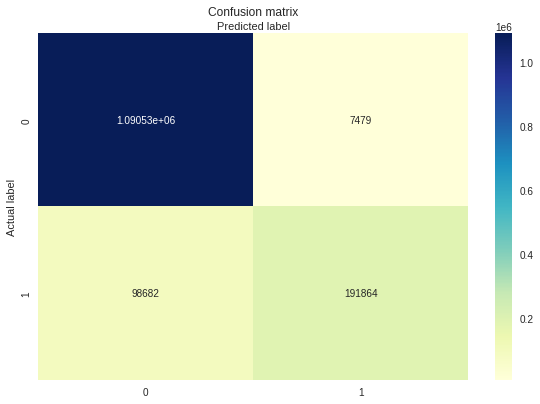

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X = Clustered_DF.drop(['DELAY_CLUSTER'], axis = 1)  # Features
y = Clustered_DF['DELAY_CLUSTER']                   # Target variable

#Split into test and training set:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=2)

#Initiating Logistic regression and fitting the model:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)


#Create Matrix:
#-----------create base
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1]        
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#------------create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#------------Print Metrics
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#### Discussion

**Explain your code and discuss results**

**CODE:**
- Data Preparation: In order to build a classification analysis, the data needs to first be structured and adapted. Therefore, after selecting all data from the flights dataset, it was combined with holidays and empty fields of the holiday column filled. Secondly, the data was further prepared, preparing subsets of the data by for example converting them from a timestamp format to an integer or splitting departure time into minutes and hours. Next, the main cluster was introduced by creating a column differentiating between SHORT (<10 min) and LONG (>= 10 min) Delays. Lastly, Columns that included Strings (e.g. Weekday) or were including unrelated information (e.g. Arrival Delay). After that the data needed to be transformed into a Pandas Dataframe. 

- Classification: The analyzed columns are the "clustered delays", therefore, the remaining data is used as features. The data is split in a tet and train set and then processed with a logistic regression to fit the model. To visualize this information, a confusion matrix is plotted and the precision, recall and accuracy are calculated. 


**DISCUSSION**

The Precision metric describes how precise/accurate a model is, calculating out of those predicted positive, how many of them are actual positive. A precision of around 96% (for the sample dataset) therefore shows, that 96 of 100 cases were predictet correctly. The model seems to work precisely (to 96%) in predicting when a delay will be long and only has a 4% Chance of detecting a delay as long when its actually short (False positive). The Recall, on the other hand, describes if a delay will be classified as short even though it is actually long (false negative). Here, the model is not as precise (69.7%) and therefore could potentially anger passengers. In Summary, the models Accuracy is 91% classifying delays correctly. This could be further imporved by taking other features into account such as the airports, the difference between wheels-in and departure, or other strings. Strings like the Airports would need to be encoded using dummy_variables. 

## Problem 4 [4 points]

Consider we want to cluster airports depending on their properties, such as average number of flights per day, delays, cancellations, etc.

Measure the quality of your clustering result.

In [22]:
# Import missing libraries to perform the cluster analysis of the properties of the airports  

from sklearn.cluster import KMeans 
import sklearn.metrics as sm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import pandas as pd
import os
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *
from sklearn.preprocessing import StandardScaler
from pyspark.ml.feature import StandardScaler

# Ignore DeprecationWarning
import warnings
warnings.filterwarnings("ignore")                           

dataframe = pd.read_csv(FLIGHTS_FILENAME,dtype=mySchema)

In [23]:
# Create DataFrame with columns for clustering
# Used Pandas instead of Spark because of personal preferences (and ease of use)

dataframe = dataframe[["ORIGIN", "FL_DATE", "DEP_DELAY", "CANCELLED"]]
dataframe.ORIGIN.unique()

# Definition of properties: flights per day // average delay // % of cancelled flights
flights_day = (dataframe.groupby("ORIGIN")["FL_DATE"].count() / 365).round().reset_index()
flights_day.rename(columns={"FL_DATE": "number_daily_flights"}, inplace = True) 
avg_delay = dataframe.groupby("ORIGIN")["DEP_DELAY"].mean().round().reset_index()
avg_delay.rename(columns={"DEP_DELAY": "avg_delay"}, inplace = True)
p_cancelled = (dataframe.groupby("ORIGIN")["CANCELLED"].sum() / dataframe.groupby("ORIGIN")["CANCELLED"].count()*100).round().reset_index()
p_cancelled.rename(columns={"CANCELLED": "perc_cancelled"}, inplace = True)

# Merge data & convert to spark dataframe
merged = flights_day.merge(avg_delay, on = ["ORIGIN"], how = "outer").merge(p_cancelled, on = ["ORIGIN"], how = "outer")
merged.drop(["ORIGIN"], inplace = True, axis =1)

df=spark.createDataFrame(merged) 
df.show(5)

+--------------------+---------+--------------+
|number_daily_flights|avg_delay|perc_cancelled|
+--------------------+---------+--------------+
|                 6.0|     10.0|           2.0|
|                 0.0|     10.0|           2.0|
|                52.0|      8.0|           1.0|
|                 2.0|      6.0|           1.0|
|                 3.0|      8.0|           0.0|
+--------------------+---------+--------------+
only showing top 5 rows



In [24]:
# Create assembler

#as features will be automatically created, we set the outputCol as "assembled_features" to differentiate assembled data from standardized data
assembler = VectorAssembler(inputCols = ['number_daily_flights', 'avg_delay', 'perc_cancelled'], outputCol='assembled_features')
data = assembler.transform(df)

# Standardizing neccessary. Despite having the same units, values show different variances. 
# Leaving variances unequal is equivalent to putting more weight on variables with smaller variance -> clusters will tend to be separated along variables with greater variance
Scaler = StandardScaler().setInputCol("assembled_features").setOutputCol("features")
data = Scaler.fit(data).transform(data)
data.show(5)

+--------------------+---------+--------------+------------------+--------------------+
|number_daily_flights|avg_delay|perc_cancelled|assembled_features|            features|
+--------------------+---------+--------------+------------------+--------------------+
|                 6.0|     10.0|           2.0|    [6.0,10.0,2.0]|[0.05092602563324...|
|                 0.0|     10.0|           2.0|    [0.0,10.0,2.0]|[0.0,0.9749781956...|
|                52.0|      8.0|           1.0|    [52.0,8.0,1.0]|[0.44135888882143...|
|                 2.0|      6.0|           1.0|     [2.0,6.0,1.0]|[0.01697534187774...|
|                 3.0|      8.0|           0.0|     [3.0,8.0,0.0]|[0.02546301281662...|
+--------------------+---------+--------------+------------------+--------------------+
only showing top 5 rows



Text(0.5, 1.0, 'Find the best number of clusters')

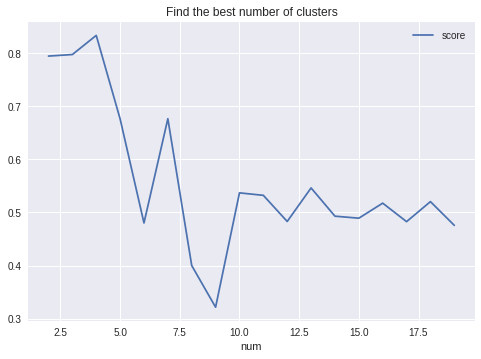

In [25]:
# Find best number of clusters and evaluate - utilizing the code from the lecture

def evaluate(data, k):
    kmeans = KMeans().setK(k).setSeed(111)
    model = kmeans.fit(data)
    predictions = model.transform(data)
    evaluator = ClusteringEvaluator()
    score = evaluator.evaluate(predictions)
    return score

results_df = pd.DataFrame(columns=['num', 'score'])
for i in range(2,20):
    results_df = results_df.append({'num': i, 'score': evaluate(data,i)}, ignore_index=True)
    
# Plot scores    
results_df.plot(x='num',y='score')
plt.title("Find the best number of clusters")

Number of clusters that produce the best result:  4 



Text(0.5, 0, '% cancelled   ')

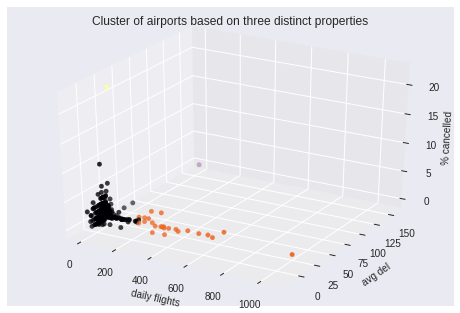

In [26]:
# Calc and print cluster that leads to a better results

k = int(results_df.nlargest(1,"score")["num"].values[0])
print("Number of clusters that produce the best result: ", k, "\n")

# K-means, fit model, centers
kmeans = KMeans().setK(k).setSeed(111)
model = kmeans.fit(data)
centers = model.clusterCenters()

# Assign data to clusters, transform to Pandas DF to be able to plot it
predictions = model.transform(data)
predictionsPD = predictions.toPandas()
#predictionsPD.head(10)

# Display results, using the cluster number as the color
ax = plt.axes(projection='3d')
ax.scatter3D(predictionsPD.number_daily_flights, predictionsPD.avg_delay, predictionsPD.perc_cancelled, c=predictionsPD.prediction, cmap="inferno")
plt.title("Cluster of airports based on three distinct properties")
ax.set_xlabel('\ndaily flights', fontsize=10, rotation=150)
ax.set_ylabel('\navg del', fontsize =10, rotation = 95)
ax.set_zlabel('% cancelled   ', fontsize=10, rotation=80)

In [27]:
# Evaluate the quality of the prediction
evaluator = ClusteringEvaluator()
score = evaluator.evaluate(predictions)
print( "Quality of predictions: ", score*100,"%")

Quality of predictions:  83.33538267104701 %


#### Discussion

**Explain your code and discuss results**

- **Code**: We started by importing the necessary libraries and loading the full dataset for the year 2016. However, the dataset didn't contain the calculated values that we wanted to base our clustering on. Hence, we had to compute the values "# of daily flights per airport", "average delay per airport" and "% cancelled per aiport" using the Pandas (simply for the ease of use and also it was much faster than the Spark code we used at the beginning, but we are not sure what led to this delayed computation time). After that we create our assembler & standardized the values (despite having the same format, the values showed significant variances - hence it is vital to standardize). Then it was basically just finding the best number of clusters, train the kmeans, and evaluate our prediction. 

- **Results**: In our case 4 clusters are proven to be ideal. From the plot we can identify two clear clusters (black and orange). Furthermore, the model's quality measured as the Silhouette Score is 83.34%. As the Silhouette Score measures how close an element is to its own cluster (cohesion) compared to other clusters (separation), it tells us that the model is relatively well matched to its own cluster as well as that the clusters a relatively well apart from each other and clearly distinguished.


## Problem 5 [3 points]

We now want to find communities of airports, i.e., airports that are connected based on the flights that exist.

Propose an algorithm to solve this problem and plot the communities as a graph. Run the program with and without GPU support.

In [28]:
edges = spark.sql("""WITH all_edges AS (SELECT ORIGIN AS src, 
                                               DEST AS dst, 
                                               COUNT(*) AS cnt
                                        FROM flights
                                        GROUP BY src, dst),
                          dep_airport AS (SELECT ORIGIN as src,
                                                  COUNT(*) AS src_cnt
                                          FROM flights
                                          GROUP BY src),
                          arr_airport AS (SELECT DEST AS dst,
                                                  COUNT(*) AS dst_cnt
                                          FROM flights
                                          GROUP BY dst)
                      SELECT e.src, e.dst, e.cnt
                      FROM all_edges e
                      LEFT JOIN dep_airport d ON e.src = d.src 
                      LEFT JOIN arr_airport a ON e.dst = a.dst 
                      WHERE d.src_cnt/e.cnt > 0.05 OR a.dst_cnt/e.cnt > 0.05
                  """)

flightsDF.createOrReplaceTempView("edges")
edges.show(5)

vertices = spark.sql( """SELECT f.id, 
                         FLOAT(TRIM(SUBSTRING_INDEX(a.coordinates,',',1))) AS lon, 
                         FLOAT(TRIM(SUBSTRING_INDEX(a.coordinates,',',-1))) AS lat
                         FROM (SELECT ORIGIN AS id FROM edges
                            UNION SELECT DEST AS id FROM edges) f 
                        JOIN airports a ON f.id = a.iata_code""").createOrReplaceTempView("vertices")


vertices_mod = spark.sql("""SELECT *
                            FROM vertices
                            WHERE lon < -50 AND lat > 15
                        """)

#vertices_mod.show(5)


+---+---+---+
|src|dst|cnt|
+---+---+---+
|DTW|BGM|877|
|ANC|DLG| 84|
|HIB|INL|365|
|MSP|INL|263|
|MCO|PSE|507|
+---+---+---+
only showing top 5 rows



In [29]:
# Run static Label Propagation Algorithm for detecting communities in networks.

import networkx as nx
from graphframes import *

g = GraphFrame(vertices_mod, edges)

result = g.labelPropagation(maxIter=2)   #maxIter = 2 because runtime with a higher Iter was just too slow

In [30]:
model = result.toPandas()

In [31]:
model.head(5)

,id,lon,lat,label
0,BTM,-112.497002,45.954800,970662608897
1,ATW,-88.519096,44.258099,970662608897
2,IND,-86.294403,39.717300,970662608897
3,LAX,-118.407997,33.942501,970662608897
4,YAK,-139.660004,59.503300,1640677507072


In [32]:
model.value_counts().head(5)

id   lon          lat        label       
YUM  -114.606003  32.656601  627065225216    1
FAT  -119.718002  36.776199  970662608897    1
EUG  -123.211998  44.124599  970662608897    1
EVV  -87.532402   38.036999  970662608897    1
EWN  -77.042900   35.073002  970662608897    1
dtype: int64

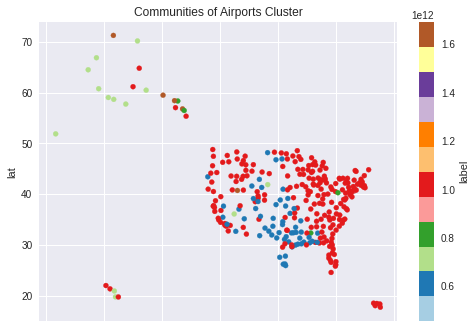

In [38]:
model.plot(x="lon",y="lat",c="label",s=25, cmap="Paired",kind="scatter",title="Communities of Airports Cluster")

#### Discussion

**Explain your code and discuss results**

- **Code**: We started by defining the edges and vertices of the graph. For the edges we counted the airports, splitted by departuring and arriving airports. Our goal was to plot just the airports which's connection is significant, in our case when more than 5% of the the flights are between to airports. Also, as an additional step, we removed all airports with a lon > -50 and a lat < 15 to clean the picture, since the default plot allocated too few space for the cluster. As a next and crucial step, we apply an a so called Label Propagation Algorithm that detects communities in networks. It assigns a label for each coordinates indicating to which community the coordinates belongs to. We are plotting the communities which can be distinguished by colour.

- **Results**: After using the graphframes library and creating a Pandas DataFrame, we were able to plot the results. The result indicates three distinguishable communities regarding the number of flights for the airport. Of course, these results are subject to several unscientific assumptions and can be improved further.
To get a better understanding of these results, it would be helpful to plot the dots on a real map.

- **Colab's GPU Support**: We used for this task both GPU support and no GPU support. To us, however, it was not entirely clear to see a benefit from the GPU support. We got the message that the GPU support is not necessary for this task and that we can run the task without the support. Hence, we assume that computing power of the computer used is sufficient for this task. We will try to experiment with Colab's GPU support in upcoming deep learning projects. 

